In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, norm
from scipy.optimize import fmin

### Read data

In [3]:
# Data set from https://www.kaggle.com/datasets/tunguz/big-five-personality-test
df = pd.read_csv('data/IPIP-FFM-data-8Nov2018/data-final.csv', delimiter='\t')
print(df.shape)
df.head()

(1015341, 110)


,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,2016-03-03 02:01:20,1360.0,768.0,12.0,179.0,11,1,MY,3.1698,101.706
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,2016-03-03 02:01:56,1366.0,768.0,3.0,186.0,7,1,GB,54.9119,-1.3833
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,2016-03-03 02:02:02,1920.0,1200.0,186.0,219.0,7,1,GB,51.75,-1.25
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,...,2016-03-03 02:02:57,1366.0,768.0,8.0,315.0,17,2,KE,1.0,38.0


### Data pre-processing 

Some questions/statements, such as EXT2 ("I don't talk a lot") are "inverted" in the sense that a high score should contribute less to extraversion. We find these and invert the scores (1 -> 5, 2 -> 4...).

In [4]:
# First, drop columns that are not answers to the test questions or IPC
columns_to_keep = [col for col in df.columns if "_E" not in col and col.isupper()]
df_clean = df[columns_to_keep]

# Drop row if number of records from the user's IP address != 1
df_clean = df_clean[df_clean['IPC'] == 1]
df_clean = df_clean.drop(columns=['IPC'])

# Remove any rows with missing values or values outside the 1-5 range
mask = df_clean.isna().any(axis=1) | ((df_clean < 1) | (df_clean > 5)).any(axis=1)
df_clean = df_clean[~mask]

inverse_score = {1:5, 2:4, 3:3, 4:2, 5:1}
inverse_questions = ["EXT2", "EXT4", "EXT6", "EXT8", "EXT10",
                    "EST2", "EST4",
                    "AGR1", "AGR3", "AGR5", "AGR7", 
                    "CSN2", "CSN4", "CSN6", "CSN8", 
                    "OPN2", "OPN4", "OPN6"]

# Invert scores for specified columns
df_clean[inverse_questions] = df_clean[inverse_questions].replace(inverse_score)

print(df_clean.shape)
df_clean.head()

(603322, 50)


,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
0,4.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,...,5.0,5.0,4.0,5.0,4.0,5.0,5.0,3.0,4.0,5.0
1,3.0,1.0,3.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,...,1.0,4.0,4.0,4.0,3.0,5.0,4.0,2.0,5.0,3.0
2,2.0,3.0,4.0,2.0,3.0,4.0,1.0,3.0,2.0,1.0,...,5.0,5.0,2.0,5.0,4.0,4.0,5.0,3.0,4.0,4.0
3,2.0,4.0,2.0,3.0,4.0,4.0,2.0,2.0,1.0,2.0,...,4.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,3.0,3.0
5,3.0,3.0,4.0,4.0,4.0,4.0,2.0,3.0,3.0,2.0,...,5.0,5.0,5.0,5.0,3.0,5.0,5.0,4.0,5.0,2.0


### Distributions

First, we check the distribution of scores as histograms. The results for conscientiousness, extraversion and neuroticism look normally distributed, whereas the results for openness and agreeableness look skewed towards a higher score.

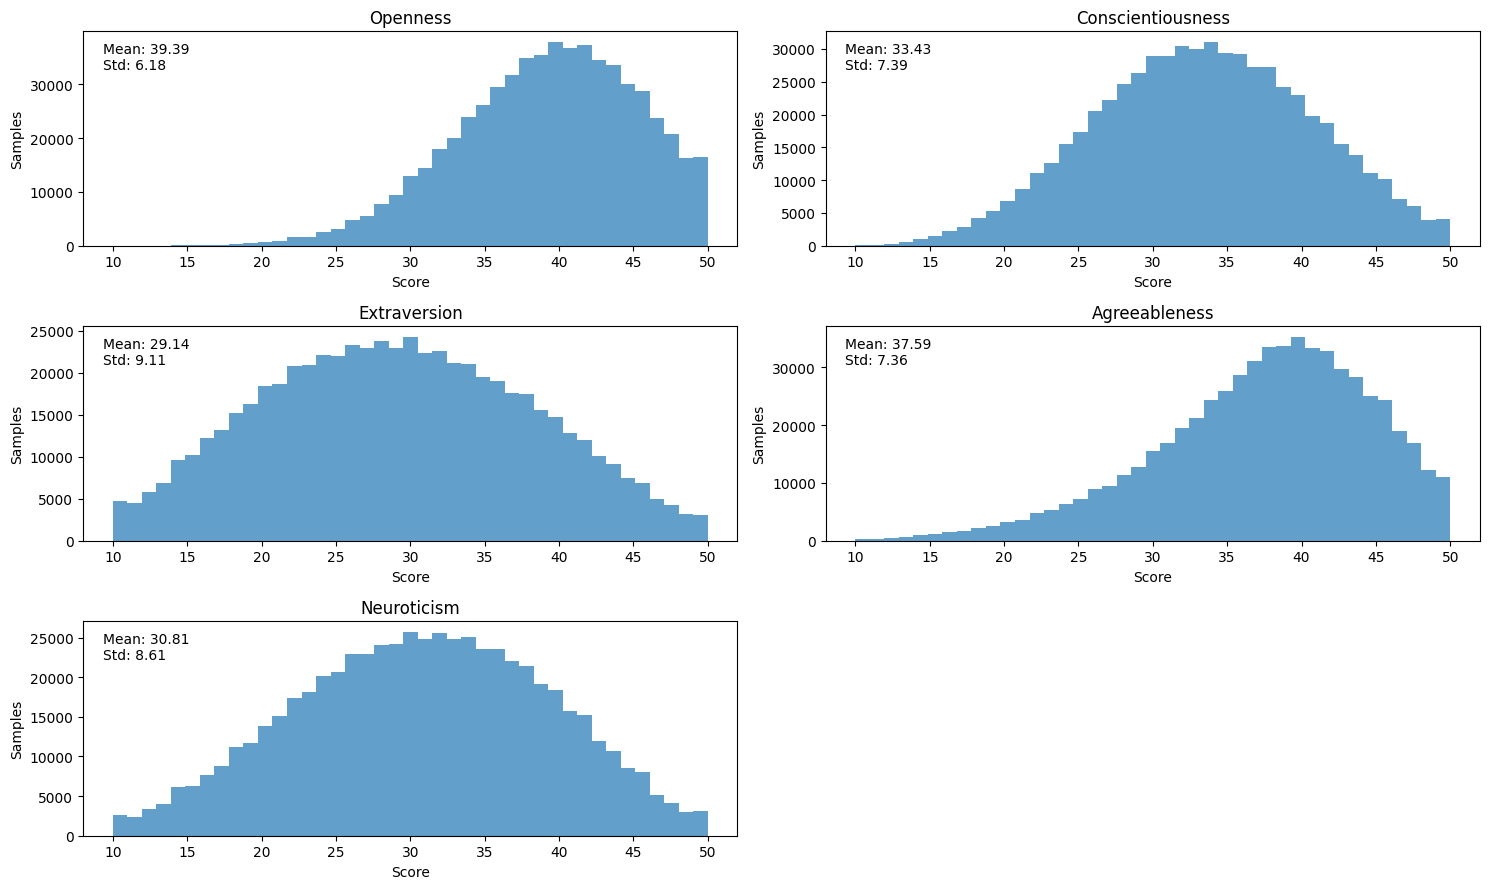

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN6,OPN7,OPN8,OPN9,OPN10,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
0,4.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,...,5.0,5.0,3.0,4.0,5.0,45.0,32.0,46.0,39.0,24.0
1,3.0,1.0,3.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,...,5.0,4.0,2.0,5.0,3.0,35.0,37.0,20.0,44.0,25.0
2,2.0,3.0,4.0,2.0,3.0,4.0,1.0,3.0,2.0,1.0,...,4.0,5.0,3.0,4.0,4.0,41.0,34.0,25.0,42.0,26.0
3,2.0,4.0,2.0,3.0,4.0,4.0,2.0,2.0,1.0,2.0,...,5.0,4.0,4.0,3.0,3.0,39.0,25.0,26.0,38.0,29.0
5,3.0,3.0,4.0,4.0,4.0,4.0,2.0,3.0,3.0,2.0,...,5.0,5.0,4.0,5.0,2.0,44.0,37.0,32.0,38.0,22.0


In [5]:
traits = {
    'Openness': [f'OPN{i}' for i in range(1, 11)],
    'Conscientiousness': [f'CSN{i}' for i in range(1, 11)],
    'Extraversion': [f'EXT{i}' for i in range(1, 11)],
    'Agreeableness': [f'AGR{i}' for i in range(1, 11)],
    'Neuroticism': [f'EST{i}' for i in range(1, 11)]
}

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))
axes = axes.flatten()

for (trait, columns), ax in zip(traits.items(), axes):
    df_clean[trait] = df_clean[columns].sum(axis=1)
    mu = df_clean[trait].mean()
    sigma = df_clean[trait].std()
    
    # 41 bins, 1 for every score between 10 and 50
    ax.hist(df_clean[trait], bins=(41), alpha=0.7)

    ax.set_title(f'{trait}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Samples')
    ax.text(0.03, 0.95, f'Mean: {mu:.2f}\nStd: {sigma:.2f}', transform=ax.transAxes, verticalalignment='top')

axes[5].axis('off')

plt.tight_layout()
plt.show()

df_clean.head()

We want to fit truncated normal distributions in the range [10, 50].

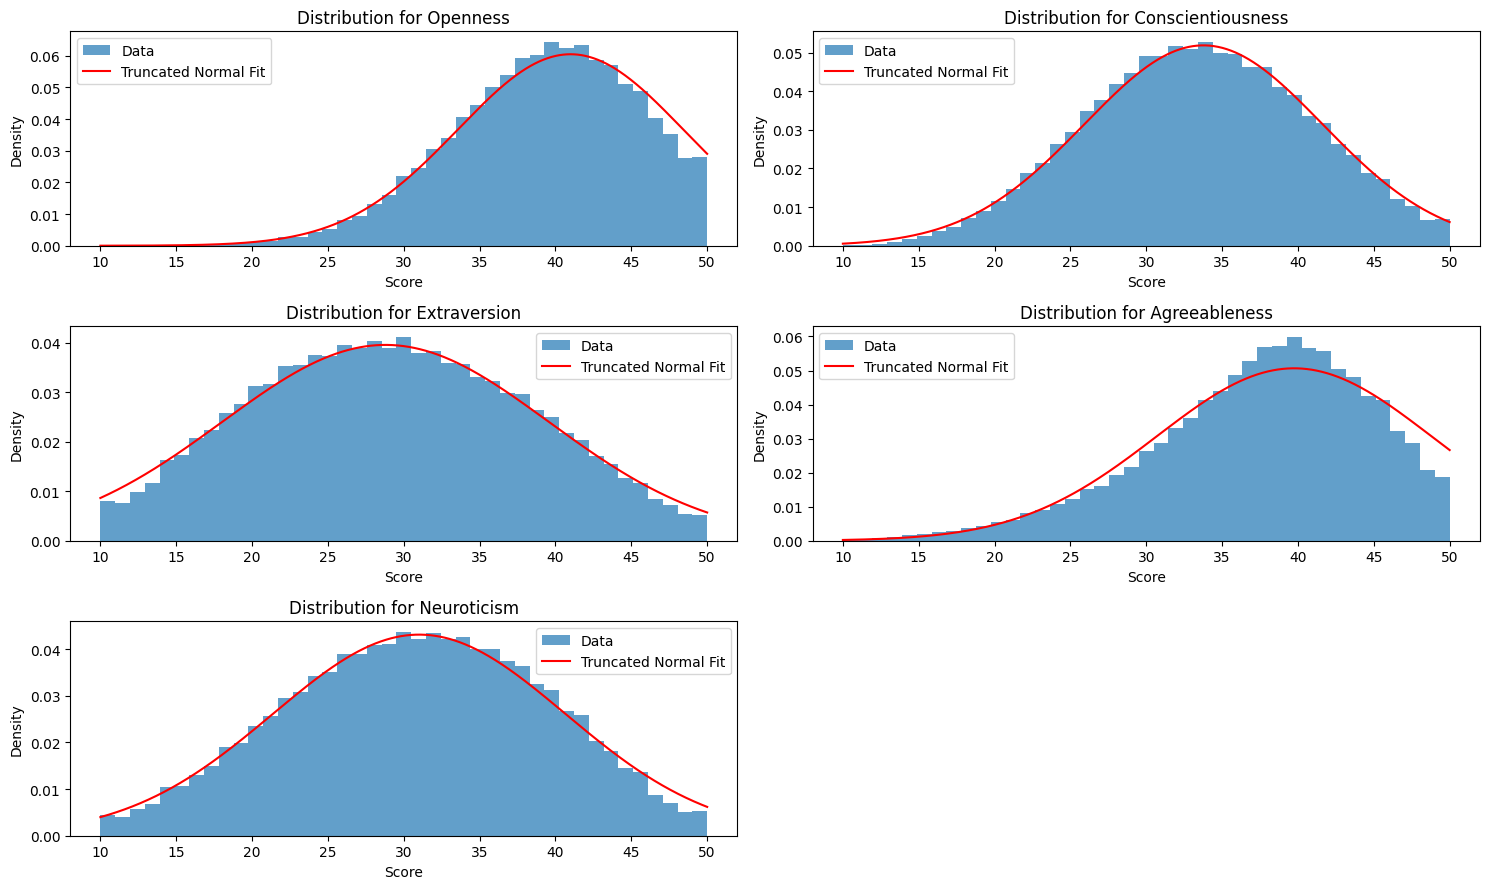

In [9]:
# Define a loss function to optimize against
def neg_log_likelihood(params, data, lower_bound, upper_bound):
    mu, sigma = params
    if sigma <= 0:
        return np.inf
    loglik = np.sum(truncnorm.logpdf(data, (lower_bound-mu)/sigma, (upper_bound-mu)/sigma, loc=mu, scale=sigma))
    return -loglik

lower_bound, upper_bound = 10, 50

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))
axes = axes.flatten()

for trait, ax in zip(traits.keys(), axes):
    data = df_clean[trait].values
    # Initial parameter estimates
    mu_init, sigma_init = np.mean(data), np.std(data)
    params_init = [mu_init, sigma_init]

    # Find parameters that minimize the negative log-likelihood
    params_estimated = fmin(neg_log_likelihood, params_init, args=(data, lower_bound, upper_bound), disp=0)

    # Plot the histogram
    ax.hist(df_clean[trait], density=True, label='Data', bins=41, alpha=0.7)

    # Plot the estimated truncated normal distribution
    x = np.linspace(lower_bound, upper_bound, 1000)
    y = truncnorm.pdf(x, (lower_bound-params_estimated[0])/params_estimated[1], \
        (upper_bound-params_estimated[0])/params_estimated[1], loc=params_estimated[0], scale=params_estimated[1])
    ax.plot(x, y, 'r-', label='Truncated Normal Fit')
    
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.set_title(f"Distribution for {trait}")
    ax.legend()

axes[5].axis('off')

plt.tight_layout()
plt.show()